In [1]:
import numpy as np
import pandas as pd
import seaborn as sn

import matplotlib.pyplot as plt
%matplotlib inline

from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from ipywidgets import interact
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from scipy.optimize import minimize

import datetime as DT

pd.options.display.max_rows = 20

### Информация о том, какое ПХГ к какой стране относится

In [2]:
ingo_vgs_countries = pd.read_excel('data/info/_main_UGS_AGSI.xlsx')

# словарь - страны и ПХГ
vgs_countries = ingo_vgs_countries['Country']
vgs_countries.index = ingo_vgs_countries['id']
dict_vgs_countries = vgs_countries.to_dict()

### Объем закачанного газа

In [3]:
def removing_nan(dataframe):
    data = dataframe.copy()
    data = data.drop(data.columns[data.isna().all()], axis=1)
    data = data.fillna(0)
    
    return data

In [4]:
def combining_columns_with_same_name(dataframe, dictionary, action = 'mean'):
    data = dataframe.copy()
    data.columns = list(map(lambda x: dictionary[x], data.columns))
    
    all_countries = data.columns
    unique_countries = all_countries.unique()

    for i in unique_countries:
        current_country = data[i].copy()

        data = data.drop(i, axis=1).copy()

        if all_countries.tolist().count(i) > 1:
            if action == 'sum':
                current_country = current_country.sum(axis = 1)
            else:
                current_country = current_country.mean(axis = 1)

        data.loc[:,i] = current_country
    return data

In [5]:
def data_cleaning(dataFrame):
    data = dataFrame.copy()
    columns = data.columns
    for i in range(len(columns)):
        q_low = data[columns[i]].quantile(0.05)
        q_hi  = data[columns[i]].quantile(0.95)

        data.loc[:, columns[i]] = data.loc[:, columns[i]].apply(lambda x: x if (x > q_low) and (x < q_hi) else None).interpolate()
    return data

In [6]:
target_injection = pd.read_excel('data/target/injection.xlsx', index_col=0, parse_dates=True)
target_injection.index = pd.DatetimeIndex(target_injection.index, freq='D')

target_injection = removing_nan(target_injection)
target_injection = combining_columns_with_same_name(target_injection, dict_vgs_countries, 'sum')
target_injection = data_cleaning(target_injection)
target_injection = removing_nan(target_injection)
target_injection['ALL'] = target_injection.sum(axis=1)
# target_injection

C:\Users\ars-b\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [7]:
target_injection

,AT,DE,BE,BG,CZ,DK,ES,FR,GB,HR,HU,IT,LV,NL,PL,PT,RO,SK,UA,ALL
Date,,,,,,,,,,,,,,,,,,,,
2011-01-01,5.270,52.20,0.00,0.0,0.0,62.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26.93,0.00,0.00,0.00,0.00,0.00,146.910
2011-01-02,4.734,49.69,0.00,0.0,0.0,21.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,27.96,0.00,0.00,0.00,0.00,0.00,104.244
2011-01-03,4.198,87.20,0.00,0.0,0.0,12.93,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28.99,0.00,0.00,0.00,0.00,0.00,133.318
2011-01-04,3.662,47.80,0.00,0.0,0.0,14.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,30.02,0.00,0.00,0.00,0.00,0.00,95.492
2011-01-05,3.126,8.40,0.00,0.0,0.0,23.24,0.00,0.20,0.00,0.00,0.00,0.00,0.00,29.52,0.00,0.00,0.00,0.00,0.00,64.486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-19,51.530,53.58,24.95,17.9,0.7,8.99,0.23,208.05,88.39,7.37,22.81,220.94,31.13,23.23,89.41,18.28,19.38,77.91,13.03,977.810
2020-03-20,102.150,62.99,25.62,17.9,0.7,4.45,0.23,286.46,175.28,7.24,22.81,246.08,31.13,23.23,89.19,19.05,39.18,71.83,13.03,1238.550
2020-03-21,88.720,79.60,24.40,17.9,0.7,13.38,0.23,346.67,100.07,5.39,22.81,494.95,31.13,64.79,89.67,19.82,49.53,71.28,13.03,1534.070


### Объем выкачанного газа

In [8]:
target_withdrawal = pd.read_excel('data/target/withdrawal.xlsx', index_col=0, parse_dates=True)
target_withdrawal.index = pd.DatetimeIndex(target_withdrawal.index, freq='D')

target_withdrawal = removing_nan(target_withdrawal)
target_withdrawal = combining_columns_with_same_name(target_withdrawal, dict_vgs_countries, 'sum')
target_withdrawal = data_cleaning(target_withdrawal)
target_withdrawal = removing_nan(target_withdrawal)
target_withdrawal['ALL'] = target_withdrawal.sum(axis=1)
# target_withdrawal

C:\Users\ars-b\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning:

Workbook contains no default style, apply openpyxl's default



### Разница объемов закачанного и выкачанного газа

In [9]:
target_injection_minus_withdrawal = target_injection - target_withdrawal

In [10]:
target_injection_minus_withdrawal

,AT,DE,BE,BG,CZ,DK,ES,FR,GB,HR,HU,IT,LV,NL,PL,PT,RO,SK,UA,ALL
Date,,,,,,,,,,,,,,,,,,,,
2011-01-01,-105.060,-79.30,-22.48,0.00,-72.36,41.210,0.00,-106.22,0.000,0.00,-266.30,-58.66,-112.62,-302.07,0.00,0.00,0.00,-167.33,0.00,-1251.190
2011-01-02,-130.986,-136.66,-21.87,0.00,-70.75,-33.450,0.00,-124.12,0.000,0.00,-265.90,-303.44,-120.67,-355.15,0.00,0.00,0.00,-189.70,0.00,-1752.696
2011-01-03,-212.902,-305.67,-23.91,-28.12,-168.78,-45.455,-114.87,-185.35,0.000,0.00,-265.50,-713.24,-124.95,-492.69,0.00,0.00,0.00,-223.91,0.00,-2905.347
2011-01-04,-216.838,-471.19,-67.39,-33.23,-158.50,-47.450,-114.44,-205.72,0.000,0.00,-265.10,-945.06,-126.90,-501.79,0.00,0.00,0.00,-265.84,0.00,-3419.448
2011-01-05,-245.934,-502.55,-34.73,-33.41,-162.90,-41.295,-104.83,-142.64,0.000,0.00,-264.70,-826.15,-123.85,-500.38,0.00,0.00,0.00,-263.23,0.00,-3246.599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-19,-140.930,-252.84,16.07,3.08,-188.30,-16.860,-68.65,-35.75,-141.110,-6.22,-51.30,182.72,19.65,-226.17,88.98,-14.83,-9.56,-37.31,10.02,-869.310
2020-03-20,-5.140,-276.53,16.74,5.29,-198.65,-23.630,-68.59,127.48,140.930,-3.48,-19.85,236.30,-2.93,-363.30,88.76,-14.06,21.06,-54.29,-64.88,-458.770
2020-03-21,-28.800,-263.19,15.52,6.50,-194.02,-12.260,-67.77,236.15,71.815,-5.72,-29.32,490.16,-2.50,-416.78,73.24,-13.29,37.59,-36.45,-92.69,-231.815


## Влияние погоды

### Соответствие тикера городу

In [11]:
predictors_weather_tickers = pd.read_excel('data/info/weather_tickers.xlsx')

# словарь- тикер и страна
tickers_countries = predictors_weather_tickers['Country']
tickers_countries.index = predictors_weather_tickers['id']

dict_tickers_countries = tickers_countries.to_dict()

### Среднесуточная температура воздуха в городах (meanTemp)

In [12]:
def parse_data_predictors(link):
    data_predictor = pd.read_excel(link)
    data_predictor.columns = data_predictor.iloc[2, :].values
    data_predictor.index = data_predictor.iloc[:, 0].values
    data_predictor = data_predictor.iloc[5:, 1:]
    data_predictor.index = pd.DatetimeIndex(data_predictor.index, freq='D')
    
    return data_predictor

In [13]:
def data_predictors_processing(dataframe):
    data = dataframe.copy()
    
    data = data.drop(data.columns[data.isna().all()], axis=1)
    data = data.fillna(method="pad")
    data = combining_columns_with_same_name(data, dict_tickers_countries)
    return data

In [14]:
predictors_meanTemp = parse_data_predictors('data/predictors/meanTemp.xlsx')
predictors_meanTemp = data_predictors_processing(predictors_meanTemp)
predictors_meanTemp['ALL'] = predictors_meanTemp.mean(axis=1)

C:\Users\ars-b\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning:

Workbook contains no default style, apply openpyxl's default



### Количество выпавших осадков в городах (precipitation)

In [15]:
predictors_precipitation = parse_data_predictors('data/predictors/precipitation.xlsx')
predictors_precipitation = data_predictors_processing(predictors_precipitation)
predictors_precipitation['ALL'] = predictors_precipitation.mean(axis=1)

### Скорость ветра в городах (windSpeed)

In [16]:
predictors_windSpeed = parse_data_predictors('data/predictors/windSpeed.xlsx')
predictors_windSpeed = data_predictors_processing(predictors_windSpeed)
predictors_windSpeed['ALL'] = predictors_windSpeed.mean(axis=1)

### Класс VGS_OF_COUNTRY

In [17]:
class VGS_OF_COUNTRY():
    def __init__(self, country_name):
        self.country_name = country_name
        self.available = True
        if self.country_name not in VGS_OF_COUNTRY.available_countries():
            self.available = False
            print('Прогноз для данной страны невозможен')
        
    @staticmethod
    def available_countries():
        array_of_all_countries = [ingo_vgs_countries['Country'],
                                    target_injection.columns,
                                    target_withdrawal.columns,
                                    predictors_meanTemp.columns,
                                    predictors_precipitation.columns,
                                    predictors_windSpeed.columns]
        available_countries = array_of_all_countries[0]
        for i in array_of_all_countries:
            available_countries = np.intersect1d(available_countries, i.unique().tolist())
        return available_countries.tolist() + ['ALL']
        
    def data_of_country(self, date_for_predict = '2020-03-09', days_for_predict = 7, windSpeed_lag = 0, precipitation_lag = 0, sample = 'train'):
        if self.available == False:
            print('Прогноз для данной страны невозможен')
            return
        if date_for_predict > '2020-03-16':
            print('Дата не может быть больше, чем 2020-03-16')
            return
        
        data = pd.DataFrame({'injection': target_injection[self.country_name].iloc[:-7]}, index=target_injection.index[:-7])
        data['withdrawal'] = target_withdrawal[self.country_name].iloc[:-7]
        data['injection_minus_withdrawal'] = target_injection_minus_withdrawal[self.country_name].iloc[:-7]
        data['meanTemp'] = predictors_meanTemp[self.country_name]
        data['windSpeed'] = predictors_windSpeed[self.country_name].shift(windSpeed_lag)
        data['precipitation'] = predictors_precipitation[self.country_name].shift(precipitation_lag)

        if sample == 'train':
            return data.loc[:date_for_predict, :]
        else:
            return data.loc[ : pd.date_range(date_for_predict, periods = days_for_predict + 1)[-1], :]
        
    def best_lag(self, attribute = 'injection_minus_withdrawal', start = 0, end = 90, step = 1):
        if self.available == False:
            print('Прогноз для данной страны невозможен')
            return
        
        max_value_windSpeed = 0
        max_index_windSpeed = 0
        max_value_precipitation = 0
        max_index_precipitation = 0

        for i in range(start, end, step):
            corr = self.data_of_country(windSpeed_lag = i, precipitation_lag = i)[[attribute, 'windSpeed', 'precipitation']].corr()
            corr_windSpeed = abs(corr.iloc[0, 1])
            corr_precipitation = abs(corr.iloc[0, 2])

            if corr_windSpeed > max_value_windSpeed:
                max_value_windSpeed = corr_windSpeed
                max_index_windSpeed = i

            if corr_precipitation > max_value_precipitation:
                max_value_precipitation = corr_precipitation
                max_index_precipitation = i

        return {'windSpeed': max_index_windSpeed, 'precipitation': max_index_precipitation}
    
    def plot_forecast(self, model, forecast):
        model.plot(forecast)
        plt.show()
    
    def metric(self, forecast, data_initial):
        metric_model_prophet = forecast.set_index('ds')[['yhat']].join(data_initial).reset_index()
        metric_model_prophet.dropna(inplace=True)
        return mean_squared_error(metric_model_prophet.iloc[:, -1], metric_model_prophet.iloc[:, -2])
    
    def compare(self, forecast, y, date_for_predict, days_for_predict):
        week_initial = self.data_of_country(date_for_predict = date_for_predict,
                                            days_for_predict = days_for_predict,
                                            sample = 'test')[y[0]][-days_for_predict:]
        week_forecast = pd.Series(data=forecast['yhat'].iloc[-days_for_predict:].values, index=week_initial.index)
    
        plt.figure(figsize=(10, 6))
        plt.title(self.country_name + ' - ' + y[0])
        plt.bar(np.arange(0, days_for_predict * 2, 2), week_initial, 0.8, label='Реальные данные')
        plt.bar(np.arange(0, days_for_predict * 2, 2) + 0.8, week_forecast, 0.8, label='Прогноз')
        plt.xticks(np.arange(0, days_for_predict * 2, 2) + 0.4, week_initial.index.strftime('%Y-%m-%d'), rotation=45)
        plt.legend()
        plt.show()
    
    def prophet(self,
                date_for_predict = '2020-03-09',
                days_for_predict = 7,
                action = 'plot',
                y = ['injection_minus_withdrawal'],
                exogs = [],
                windSpeed_lag = 0,
                precipitation_lag = 0):
        
        if self.available == False:
            print('Прогноз для данной страны невозможен')
            return 
        
        if (pd.to_datetime('2020-03-16') - pd.to_datetime(date_for_predict)).days < 1:
            print('Прогноз можно делать до 2020-03-16')
            return 
        
        if (pd.to_datetime('2020-03-16') - pd.to_datetime(date_for_predict)).days < days_for_predict:
            print('Прогноз можно делать с ' + date_for_predict + ' до 2020-03-16, то есть максимальное число дней для прогноза равно ' +
                  str((pd.to_datetime('2020-03-16') - pd.to_datetime(date_for_predict)).days))
            return
        
        available_exogs = ['meanTemp', 'windSpeed', 'precipitation']
        available_y = ['injection_minus_withdrawal', 'withdrawal', 'injection']
        
        selected_country = self.data_of_country(date_for_predict, days_for_predict, windSpeed_lag, precipitation_lag)
        data_prophet = selected_country.copy()
        data_prophet = data_prophet.reset_index()
        data_prophet = data_prophet.dropna()
        data_prophet = data_prophet.drop(list(set(available_y) - set(y)) + list(set(available_exogs) - set(exogs)), axis=1)
        data_prophet.columns = ['ds', 'y'] + exogs
                
        model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
        model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
        model.add_seasonality(name='weekly', period=7, fourier_order=10)
        for i in exogs:  
            model.add_regressor(i)
        model.fit(data_prophet)
        
        selected_country_test = self.data_of_country(date_for_predict, days_for_predict, windSpeed_lag, precipitation_lag, sample = 'test')
        future = model.make_future_dataframe(periods = days_for_predict, freq='D')
        for i in exogs:  
            future[i] = selected_country_test[i].values
        forecast = model.predict(future)
        
        if action == 'plot':
            self.plot_forecast(model, forecast)
        elif action == 'error':
            return self.metric(forecast, selected_country_test[y[0]])
        elif action == 'compare':
            self.compare(forecast, y, date_for_predict, days_for_predict)
        else:
            return forecast
            
            
    def prophet_separately(self,
                date_for_predict = '2020-03-09',
                days_for_predict = 7,
                action = 'plot',
                exogs = [],
                windSpeed_lag = 0,
                precipitation_lag = 0):
        
        prophet_injection = self.prophet(date_for_predict = date_for_predict,
                days_for_predict = days_for_predict,
                action = 'data',
                y = ['injection'],
                exogs = exogs,
                windSpeed_lag = windSpeed_lag,
                precipitation_lag = precipitation_lag)
        
        prophet_withdrawal = self.prophet(date_for_predict = date_for_predict,
                days_for_predict = days_for_predict,
                action = 'data',
                y = ['withdrawal'],
                exogs = exogs,
                windSpeed_lag = windSpeed_lag,
                precipitation_lag = precipitation_lag)
        
        prophet_VGS = prophet_injection.copy()
        prophet_VGS.iloc[:, 2:] =  prophet_injection.iloc[:, 2:] - prophet_withdrawal.iloc[:, 2:]
        
        selected_country_test = self.data_of_country(date_for_predict, days_for_predict, windSpeed_lag, precipitation_lag, sample = 'test')
               
        if action == 'error':
            return self.metric(prophet_VGS, selected_country_test['injection_minus_withdrawal'])
        elif action == 'compare':
            self.compare(prophet_VGS, ['injection_minus_withdrawal'], date_for_predict, days_for_predict)
        else:
            return forecast
        
        

In [18]:
VGS_OF_COUNTRY.available_countries()

['AT',
 'BE',
 'BG',
 'CZ',
 'DE',
 'DK',
 'ES',
 'FR',
 'GB',
 'HR',
 'HU',
 'IT',
 'NL',
 'PL',
 'PT',
 'RO',
 'SK',
 'ALL']

### Экземпляр класса

In [19]:
country = VGS_OF_COUNTRY('AT')

In [20]:
country.country_name

'AT'

### Наилучшие лаги

In [21]:
lags = country.best_lag(attribute = 'injection_minus_withdrawal',
                 start = 0,
                 end = 90,
                 step = 1)
lags

{'windSpeed': 89, 'precipitation': 6}

### Метод prophet для экземпляра класса

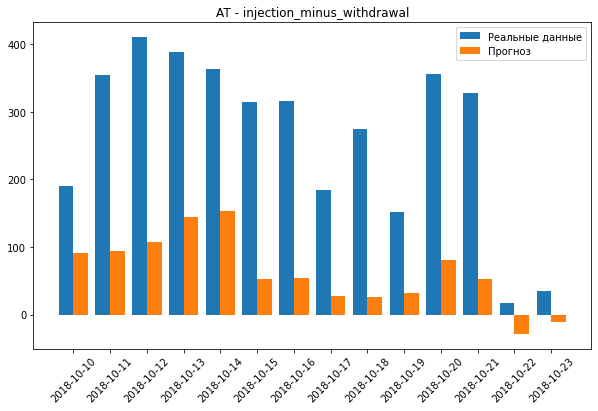

In [22]:
country.prophet(action = 'compare', # plot  | error | compare | data
                date_for_predict = '2018-10-09',
                days_for_predict = 14,
                exogs = ['meanTemp'], # ['meanTemp', 'windSpeed', 'precipitation']
                y = ['injection_minus_withdrawal'], # ['injection_minus_withdrawal'] | ['withdrawal'] | ['injection']
                windSpeed_lag = 0,
                precipitation_lag = 0)

### Метод prophet_separately для экземпляра класса

In [23]:
country.prophet_separately(action = 'error', # error | compare | data
                date_for_predict = '2020-03-09',
                days_for_predict = 7,
                exogs = ['meanTemp', 'windSpeed', 'precipitation'], # ['meanTemp', 'windSpeed', 'precipitation']
                windSpeed_lag = lags['windSpeed'],
                precipitation_lag = lags['precipitation'])

14375.314545449322

### Интерактивный режим

In [24]:
@interact(country = ['DE','FR','IT','GB','NL','AT','HU', 'ALL'],
          action = ['plot', 'error', 'compare', 'data'],
          days_for_predict = (7, 21, 1),
          exogs = [[], ['meanTemp'], ['meanTemp', 'windSpeed', 'precipitation']],
          y = [['injection_minus_withdrawal'], ['withdrawal'], ['injection']],
          windSpeed_lag = (0, 90, 10),
          precipitation_lag = (0, 90, 10)) 
def plot_country_prophet(country, action, days_for_predict, exogs, y, windSpeed_lag, precipitation_lag):
    current_country = VGS_OF_COUNTRY(country)
    current_country.prophet(action = action,
                date_for_predict = '2019-06-09',
                days_for_predict = days_for_predict,
                exogs = exogs,
                y = y,
                windSpeed_lag = windSpeed_lag,
                precipitation_lag = precipitation_lag)

interactive(children=(Dropdown(description='country', options=('DE', 'FR', 'IT', 'GB', 'NL', 'AT', 'HU', 'ALL'…

### MSE для основных стран

In [25]:
for i in ['DE','FR','IT','GB','NL','AT','HU']:
    current_country = VGS_OF_COUNTRY(i)
    error = current_country.prophet(action = 'error', # plot  | error | compare | data
                    date_for_predict = '2020-03-09',
                    days_for_predict = 7,
                    exogs = ['meanTemp', 'windSpeed', 'precipitation'], # ['meanTemp', 'windSpeed', 'precipitation']
                    y = ['injection_minus_withdrawal'], # ['injection_minus_withdrawal'] | ['withdrawal'] | ['injection']
                    windSpeed_lag = lags['windSpeed'],
                    precipitation_lag = lags['precipitation'])
    print('Error for ' + i + ' : ' + str(error))

Error for DE : 78033.86937962017
Error for FR : 46013.59678325664
Error for IT : 31438.48953848846
Error for GB : 6440.174274192733
Error for NL : 51884.0457162226
Error for AT : 14767.464096204378
Error for HU : 3657.708701507236


### Сравнение начальных данных и прогнозных для основных стран

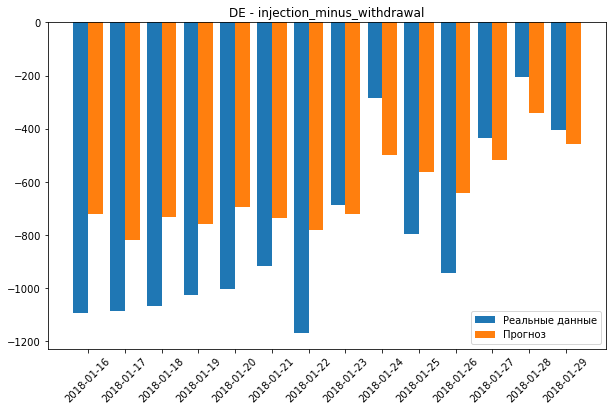

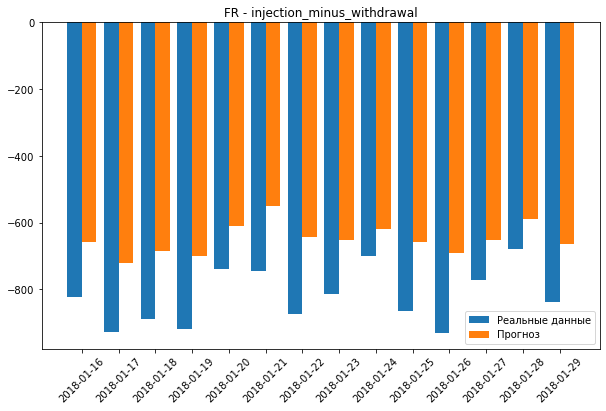

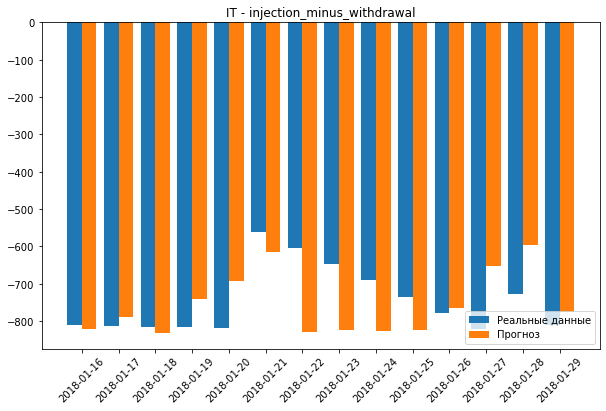

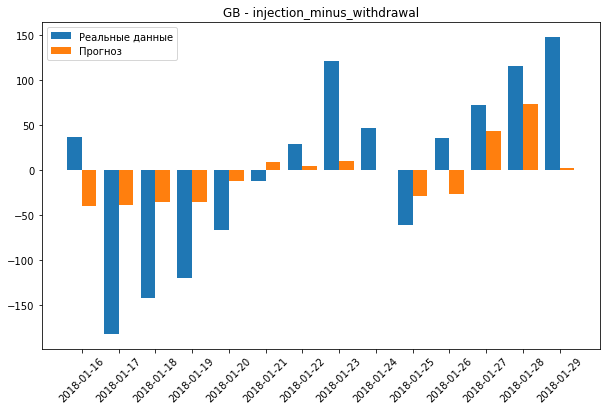

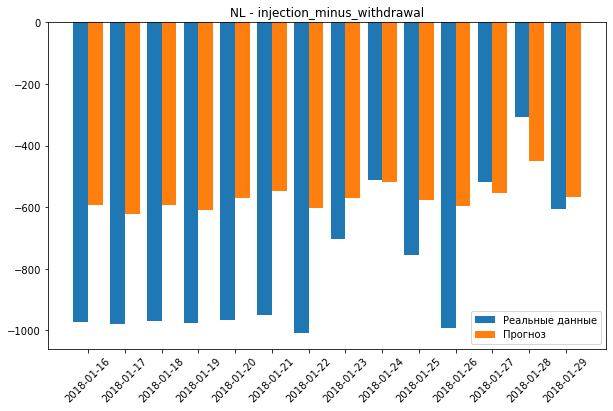

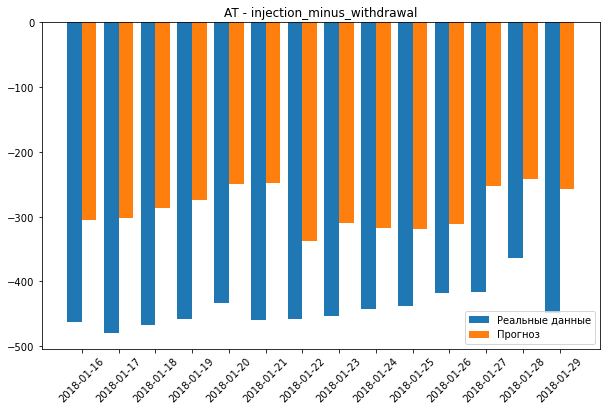

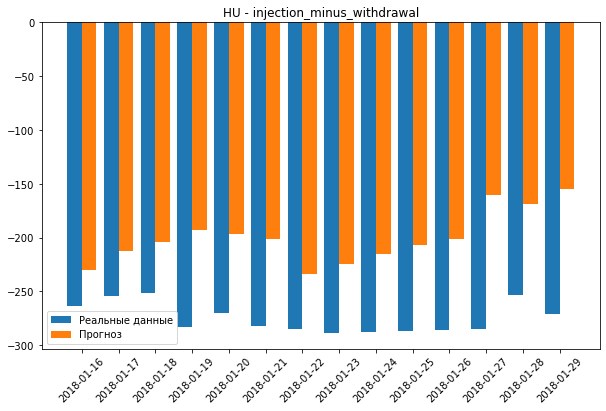

In [26]:
for i in ['DE','FR','IT','GB','NL','AT','HU']:
    VGS_OF_COUNTRY(i).prophet_separately(action = 'compare', # plot  | error | compare | data
                date_for_predict = '2018-01-15',
                days_for_predict = 14,
                exogs = ['meanTemp'], # ['meanTemp', 'windSpeed', 'precipitation']
                windSpeed_lag = 0,
                precipitation_lag = 0)